In [1]:
!python --version

Python 3.7.12


In [ ]:
# !pip list

In [2]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from tqdm.auto import tqdm
import csv

In [3]:
# # Download caption annotation files
# annotation_folder = '/annotations/'
# if not os.path.exists(os.path.abspath('.') + annotation_folder):
#   annotation_zip = tf.keras.utils.get_file('captions.zip',
#                                           cache_subdir=os.path.abspath('.'),
#                                           origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
#                                           extract = True)
#   annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_val2014.json'
#   os.remove(annotation_zip)

# # Download image files
# image_folder = '/val2014/'
# if not os.path.exists(os.path.abspath('.') + image_folder):
#   image_zip = tf.keras.utils.get_file('val2014.zip',
#                                       cache_subdir=os.path.abspath('.'),
#                                       origin = 'http://images.cocodataset.org/zips/val2014.zip',
#                                       extract = True)
#   PATH = os.path.dirname(image_zip) + image_folder
#   os.remove(image_zip)
# else:
#   PATH = os.path.abspath('.') + image_folder

In [4]:
annotation_file = '/kaggle/input/coco-val2014-gender-dataset/gender_annotations.json'

PATH = '/kaggle/input/coco-val2014-gender-dataset/genderval2014/genderval2014/'

In [5]:
# Read the json file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_val2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)
    
# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

In [6]:
train_captions = train_captions[:30000]
img_name_vector = img_name_vector[:30000]

In [7]:
len(train_captions), len(all_captions)

(30000, 91502)

In [8]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [9]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output #(8x8x2048)

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 0s 0us/step


In [10]:
# !pip install -q tqdm

In [11]:
from tqdm import tqdm

In [12]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

In [13]:
save_dir = "/kaggle/working/features/"
os.makedirs(save_dir, exist_ok=True) 

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
      file_name = os.path.basename(p.numpy().decode("utf-8"))
      path_of_feature = os.path.join(save_dir, file_name + ".npy")
      np.save(path_of_feature, bf.numpy())

100%|██████████| 989/989 [02:06<00:00,  7.83it/s]


In [14]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [15]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [16]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [17]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [18]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [19]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [20]:
# # Create training and validation sets using an 80-20 split
# img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
#                                                                     cap_vector,
#                                                                     test_size=0.0333,
#                                                                     random_state=0)

In [21]:
img_name_train, img_name_temp, cap_train, cap_temp = train_test_split(
    img_name_vector, cap_vector, test_size=0.30, random_state=0)

img_name_val, img_name_test, cap_val, cap_test = train_test_split(
    img_name_temp, cap_temp, test_size=0.3333, random_state=0)  

# Output dataset sizes
print(f"Training set: {len(img_name_train)} samples")
print(f"Validation set: {len(img_name_val)} samples")
print(f"Test set: {len(img_name_test)} samples")

Training set: 21000 samples
Validation set: 6000 samples
Test set: 3000 samples


In [22]:
# len(img_name_train), len(img_name_val),len(img_name_test)

In [23]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [24]:
# Load the numpy files
def map_func(img_name, cap):
    feature_dir = "/kaggle/working/features/"
    file_name = os.path.basename(img_name.decode('utf-8')) + ".npy"
    img_tensor = np.load(os.path.join(feature_dir, file_name))
    return img_tensor, cap

In [25]:
def create_dataset(images,captions):
  dataset = tf.data.Dataset.from_tensor_slices((images, captions))

  # Use map to load the numpy files in parallel
  dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)

  # Shuffle and batch
  dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [26]:
# dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# # Use map to load the numpy files in parallel
# dataset = dataset.map(lambda item1, item2: tf.numpy_function(
#           map_func, [item1, item2], [tf.float32, tf.int32]),
#           num_parallel_calls=tf.data.experimental.AUTOTUNE)

# # Shuffle and batch
# dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [27]:
# Creating train, val and test dataset
train_dataset = create_dataset(img_name_train,cap_train)
val_dataset=create_dataset(img_name_val,cap_val)
test_dataset = create_dataset(img_name_test,cap_test)

In [28]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)
    
    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    
    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)
    
    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)
    
    return context_vector, attention_weights

In [29]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [30]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)
  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights
  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [31]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [32]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [41]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [42]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [43]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [44]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)
          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [45]:
val_loss_plot = []

In [46]:
@tf.function
def val_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  features = encoder(img_tensor)

  for i in range(1, target.shape[1]):
      # passing the features through the decoder

      
      predictions, hidden, _= decoder(dec_input, features, hidden)
      # predictions : (64,8329)
      loss += loss_function(target[:, i], predictions)
      
      predicted_id = tf.argmax(predictions[0])
      dec_input = tf.expand_dims([predicted_id]*target.shape[0], 1)
 

  total_loss = (loss / int(target.shape[1]))

  return loss, total_loss

In [47]:
EPOCHS = 30

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    total_loss_val = 0
    for (batch, (img_tensor, target)) in enumerate(val_dataset):
        batch_loss, v_loss = val_step(img_tensor, target)
        total_loss_val += v_loss
    # storing the epoch end loss value to plot later
    val_loss_plot.append(total_loss_val / num_steps) 

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} TrainLoss {:.6f} ValLoss {:.6f}'.format(epoch + 1,(total_loss/num_steps),(total_loss_val/num_steps)))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.9113
Epoch 1 Batch 100 Loss 1.2444
Epoch 1 Batch 200 Loss 0.9534
Epoch 1 Batch 300 Loss 0.8858
Epoch 1 TrainLoss 1.027756 ValLoss 0.381344
Time taken for 1 epoch 179.42139410972595 sec

Epoch 2 Batch 0 Loss 0.8939
Epoch 2 Batch 100 Loss 0.8164
Epoch 2 Batch 200 Loss 0.8290
Epoch 2 Batch 300 Loss 0.7204
Epoch 2 TrainLoss 0.786917 ValLoss 0.395521
Time taken for 1 epoch 68.11884570121765 sec

Epoch 3 Batch 0 Loss 0.6926
Epoch 3 Batch 100 Loss 0.6895
Epoch 3 Batch 200 Loss 0.6665
Epoch 3 Batch 300 Loss 0.7134
Epoch 3 TrainLoss 0.711844 ValLoss 0.402320
Time taken for 1 epoch 67.5367522239685 sec

Epoch 4 Batch 0 Loss 0.7079
Epoch 4 Batch 100 Loss 0.6653
Epoch 4 Batch 200 Loss 0.6149
Epoch 4 Batch 300 Loss 0.6398
Epoch 4 TrainLoss 0.664537 ValLoss 0.402827
Time taken for 1 epoch 67.78271651268005 sec

Epoch 5 Batch 0 Loss 0.5975
Epoch 5 Batch 100 Loss 0.6328
Epoch 5 Batch 200 Loss 0.5880
Epoch 5 Batch 300 Loss 0.6491
Epoch 5 TrainLoss 0.627992 ValLoss 0.407366
Time t

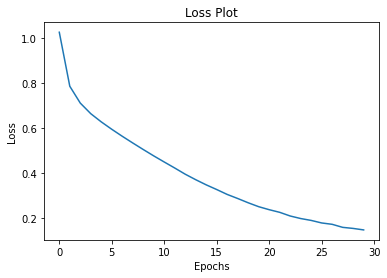

In [48]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

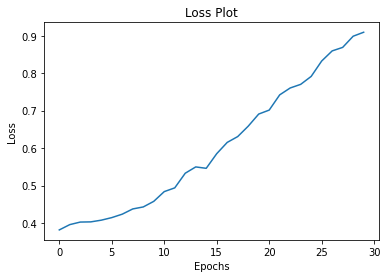

In [49]:
plt.plot(val_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [50]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot
def evaluate_without_plot(image):
    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    attention_weights_dict = {"man": None, "woman": None}
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] in attention_weights_dict:
            attention_weights_dict[tokenizer.index_word[predicted_id]] = attention_weights.numpy()

        if tokenizer.index_word[predicted_id] == '<end>':
            return result,attention_weights_dict
    
        dec_input = tf.expand_dims([predicted_id], 0)

    return result,attention_weights_dict

In [51]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
# # captions on the validation set
# rid = np.random.randint(0, len(img_name_val))
# image = img_name_val[rid]
# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
# result, attention_plot = evaluate(image)

# print ('Real Caption:', real_caption)
# print ('Prediction Caption:', ' '.join(result))
# plot_attention(image, result, attention_plot)

In [52]:
real_captions = []
pred_captions = []

with open('./test_captions.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerow(["filename","true_caption", "pred_caption", "gen_atten_weights"])

    for idx in tqdm(range(len(img_name_test))):
        filename = os.path.basename(img_name_test[idx])
        r_cap = [tokenizer.index_word[i] for i in cap_test[idx] if i not in [0]][1:-1]
        p_cap,aw_cap = evaluate_without_plot(img_name_test[idx])
    
        real_captions.append(r_cap)
        pred_captions.append(p_cap)

        writer.writerow([filename,' '.join(r_cap), ' '.join(p_cap), aw_cap])

100%|██████████| 3000/3000 [10:10<00:00,  4.92it/s]
